In [2]:
rules = [
#     (name, note, function_name)
    ('income', 'must be less than X', 'income_less_than(100000)'),
    ('dependents', 'must be less than X', 'dependents_greater_than(0)'),
    ('rate', 'must be greater than X', 'rate_greater_than(0)'),
#     TODO: only run these if the above are true...
    ('minimum_payout', '', 'payout_min()'),
    ('maximum_payout', '', 'payout_max()')
]


In [3]:
# person definition
#        (income, dependents, rate_amount)
person = (60000, 3, 2000)

# the entitlement for the rebate
rebate_amount = 0


# Logic rule implementations
def income_less_than(x):
    if person[0] < x:
        return True
    return False

def dependents_greater_than(x):
    if person[1] > x:
        return True
    return False

def rate_greater_than(amount):
    return person[2] > amount

def payout_max():
    if person[1] > 1:
        global rebate_amount
        rebate_amount = 600
    return True
    
def payout_min():
    if person[1] == 1:
        global rebate_amount
        rebate_amount = 180
    return True

In [4]:

def get_results():
    "evaluate the rules and output results"
    results = []
    for rule in rules:
        result = eval(rule[2])
        results.append(result)

    if all(results):
        print("You are entitled, and get a rebate of", rebate_amount)
    else:
        print("failed because:")
        for i, x in enumerate(results):
            if not x:
                print(rules[i])


# if all([eval(rule[2]) for rule in rules]):
#     print("person is entitled to a rates rebate:", r)
# else:
    

In [5]:
person = (60000, 1, 2000)
get_results()

You are entitled, and get a rebate of 180


# Question model as code 

The nodes defined below are our set of facts about the state of the rates rebate legislation.
We can represent these as a question model, or as rules for a decision making framework.

The array format below is the format suitable for rendering as a graph. To use it in a decision framework we want something a bit more tree-like

In [9]:

nodes = [
    ('goal', 'What is the amount\nof rates subsidy a\nperson is entitled to?', ['dependants', 'current_rate', 'income', 'is_qualified'], 'calculate_subsidy'),
    ('is_qualified', 'you are qualified to recieve a subsidy', ['is_ratepayer', 'is_living_in_house', 'is_residential'], None),
    ('is_ratepayer', 'Are you a ratepayer?', [], None),
    ('is_living_in_house', 'Are you living in the house?', [], None),
    ('is_residential', 'Is the house residential?', [], None),
    ('dependants', 'What is the number of dependants the ratepayer has?', ['dependants_children', 'dependants_relatives'], None),
    ('current_rate', 'What is the amount of rates?', [], None),
    ('income_household', "What is the joint homeowner's taxable income",[], None),
    ('income', 'What is your ratepayers income?', ['income_joint', 'income_personal', 'income_household'], None),
    ('income_joint', "What is the ratepayer's taxable income?", [], None),
    ('income_personal', "What is the spouse/partner's income?", ['income_spouse'], None),
    ('income_spouse', "Is there a spouse/partner ordinarily resident?", [], None),
    ('dependants_children', 'What is the number of dependent children the ratepayer has?', [], None),
    ('dependants_relatives', 'What is the number of dependant relatives the ratepayer has?', [], None),
]

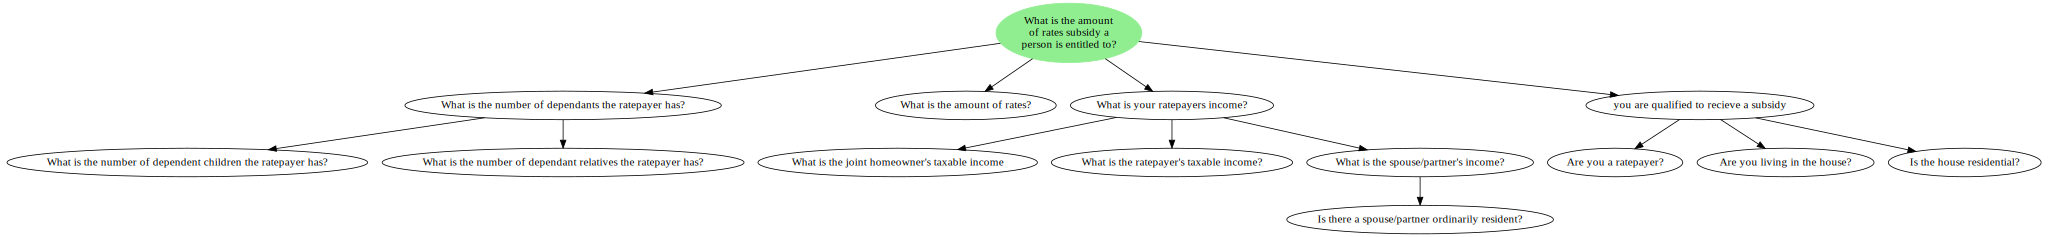

In [10]:
from graphviz import *


  
questions = Digraph(name='questions')
questions.attr(overlap='false')

for name, description, dependants, fn in nodes:
    edges = [(name, d) for d in dependants]
    if name == 'goal':
        questions.node(name, description, style='filled', color='lightgreen')
    questions.node(name, description)
    questions.edges(edges)

questions.render('dist/questions.graph')
questions

# Rates rebate decision model as code

Using the documentation [here](https://docs.google.com/document/d/1b4RxWRqXb65X2POi4NMRMMrSMJQ3bgKO9SgRGjJev8E/edit) as a basis for implementing literate python for the implementation of the rates rebate calculation.


For the purpose of this investigation we are ignoring the new Section 7A (Refund to resident of retirement village of contribution towards rates)


In [1]:
# definitions
from datetime import date
import datetime

### _Ratepayer_ means:

At the _relevant_date_:

1. A person is the ratepayer of a property if the person appears as the ratepayer on the rating register of the council the person applies to.

**OR**

2. A person is the ratepayer of a property if the person lives in a retirement home.

In [2]:
is_ratepayer = False

def is_ratepayer(person_exists_on_ratepayer_register, is_retirement_village_resident):
    return person_exists_on_ratepayer_register or is_retirement_village_resident


### _Residential Property_ means:

(a) a rating unit under the Local Government (Rating) Act 2002 that is used as the usual place of residence of the ratepayer at the commencement of the rating year in respect of which an application for a rebate under this Act is made, but does not include any unit that is also used principally for commercial or industrial or business or farming purposes; or

(b) a rating unit under the Local Government (Rating) Act 2002 that is used as a retirement village at the commencement of the rating year in respect of which an application for a refund under section 7A is made

In [3]:

def residential_property(usual_place_of_residence, is_ratepayer_of_property, is_retirement_village, purpose_is_farming, purpose_is_industrial):
    """
    A function to calculate if the person has a residential property
    
    usual_place_of_residence: Is this your your place of residence on the relevant_date? yes/no
    is_ratepayer_of_property: Is this a property you pay rates for? yes/No
    is_retirement_village: Is the person living in a retirement_village? yes/no
    purpose_is_farming: Is the main purpose of the property farming related?
    purpose_is_industrial: Is the main purpose of the property industrial?
    """
    if is_retirement_village:
            return True
    if not purpose_is_farming and not purpose_is_industrial:
        if usual_place_of_residence and is_ratepayer_of_property:
            return True
    return False
    

### _Relevant date_ means:

The relevant date is the date at the commencement of the rating year the person applies for the rating subsidy.

The date at the commencement of the rating year is 1 July of the rating year.



In [4]:
relevant_date = date(date.today().year, 7, 1)

### _Eligibility_ means:

- 

In [5]:
def is_eligible():
    "Determine if the person is eligble for the rates_calculation"
    if residential_property():
        return True
    if is_retirement_village:
        return True

    if is_ratepayer and is_residential_property:
        return True

    return False
    
    

# Rates calculation
Rates subsidy = household income - baserate / dependents.number * 10% * rates 

- base_rate is a constant included in the calculation with the value 15,0000.


In [6]:
base_rate = 15000
def rate_subsidy_calculation(household_income, dependants_number, rate):
    return (household_income - base_rate) / (dependants_number * 0.1 * rate)


In [7]:
rate_subsidy_calculation(45000, 2, 2000)

75.0